# 5.3.延后初始化


:label:`sec_deferred_init`

到目前为止，我们忽略建立网络时考虑以下这些事情：

* 我们定义了网络架构，但没有指定输入维度。
* 我们添加层时没有指定前一层的输出维度。
* 我们在初始化参数时，甚至没有足够的信息来确定模型应该包含多少参数。

你可能会对我们的代码能运行感到惊讶。
毕竟，深度学习框架无法判断网络的输入维度是什么。
这里的诀窍是框架的**延后初始化建立网络**（defers initialization），
即直到数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。

在以后，当使用卷积神经网络时，
由于输入维度（即图像的分辨率）将影响每个后续层的维数，
有了该技术将更加方便(动态推出每一层的大小)。
现在我们在编写代码时无须知道维度是什么就可以设置参数，
这种能力可以大大简化定义和修改模型的任务。
接下来，我们将更深入地研究初始化机制。

## 5.3.1.实例化网络

首先，让我们实例化一个多层感知机(这里只给出了延后初始化的一个特殊的例子nn.LazyLinear模块，当然还有其他的模块，比如：nn.LazyConv2d()模块）
此时，因为输入维数是未知的，所以网络不可能知道输入层权重的维数。


In [2]:
import torch
from torch import nn#从torch里面导入nn模块

#用nn.sequential模块定义了包含一个隐藏层的多层感知机
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
print(net) # 尚未初始化
#z注意：nn.LazyLinear()模块的API或功能随时可能发生。
#API应用程序编程接口

Sequential(
  (0): LazyLinear(in_features=0, out_features=256, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=10, bias=True)
)


D:\app\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



nn.lazyLinear模块的介绍:https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html?highlight=lazylinear#torch.nn.LazyLinear

#nn.LazyLinear类似于nn.Linear()只是没有输入的维数,只有输出的维数

y=XW+b

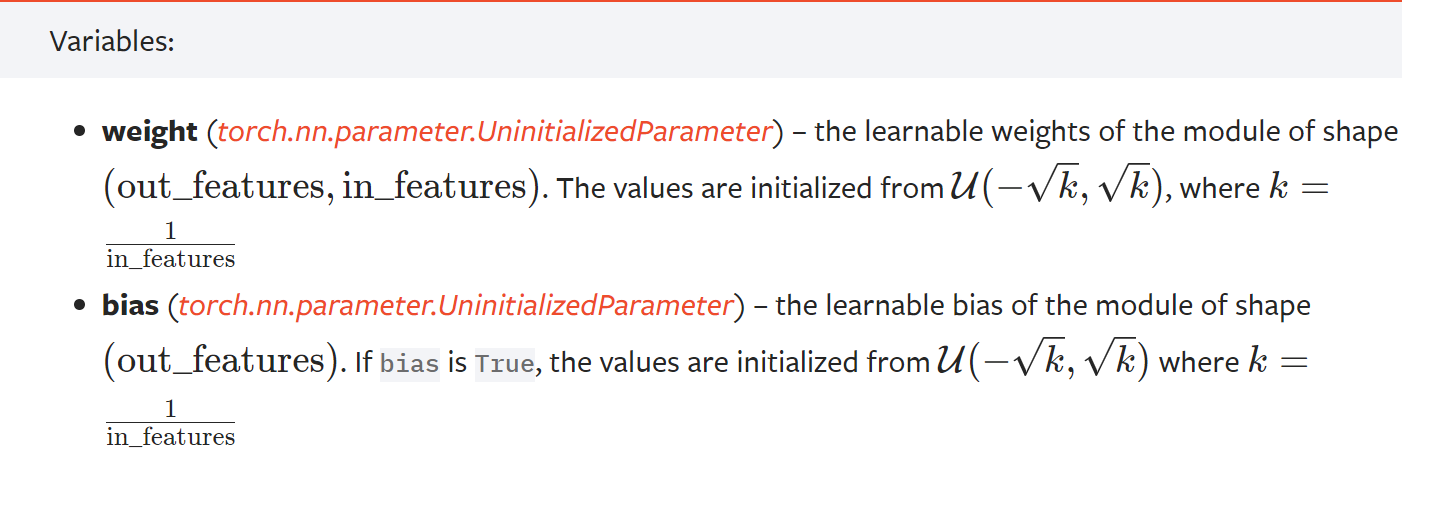

nn.sequential方法说明：https://pytorch.org/docs/stable/_modules/torch/nn/modules/container.html#Sequential

nn.Sequential是一个Sequential容器，模块将按照构造函数中传递的顺序添加到模块中。那么前一个函数的输出作为后边一个函数的输入，依次进行


In [1]:
import torch.nn as nn
from collections import OrderedDict
# Sequential使用实例
#直接将一系列子模块作为参数传入
model = nn.Sequential(
          nn.Linear(1,20,5),
          nn.ReLU(),
          nn.Linear(20,64,5),
          nn.ReLU()
        )

# Sequential with OrderedDict使用实例(模块的有序字典作为传入)，不可以用名称进行访问，仍然需要用索引进行访问
model1 = nn.Sequential(OrderedDict([
          ('linear1', nn.Linear(1,20,5)),
          ('relu1', nn.ReLU()),
          ('linear2', nn.Linear(20,64,5)),
          ('relu2', nn.ReLU())
        ]))
#以上两种形式为一致。一种自动命名0，1，2，3，一种指定名字
print(model)
print(model1)
print(type(model1))
print(type(model))
model[0],model1[0]#model['linear1']报错

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=64, bias=True)
  (3): ReLU()
)
Sequential(
  (linear1): Linear(in_features=1, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=64, bias=True)
  (relu2): ReLU()
)
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>


(Linear(in_features=1, out_features=20, bias=True),
 Linear(in_features=1, out_features=20, bias=True))

In [3]:
net[0].weight#因为权重的形状由输入的维数决定，输入的维数不知所以权重的形状也不知道，所以参数没有被初始化

<UninitializedParameter>

In [4]:
#接下来让我们让数据通过网络，最终使框架初始化（也就是参数：权重和偏执进行初始化）。
X = torch.rand(2, 20)#生成[0,1]上的均匀分布
#数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。
net(X)
print(net)
print(net[0].weight.data)#输出第一层的权重的值，.data表示去掉梯度
print(net[0].bias.data[0])#输出第一层的偏执

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)
tensor([[ 0.1019, -0.1653, -0.0151,  ..., -0.1197, -0.2191,  0.0396],
        [-0.1216, -0.0589,  0.1686,  ..., -0.1449, -0.0140,  0.1696],
        [-0.1934, -0.2193, -0.2095,  ...,  0.0432, -0.0927, -0.0570],
        ...,
        [ 0.1774,  0.1855, -0.0178,  ..., -0.0063,  0.1563, -0.0869],
        [ 0.0760, -0.1760, -0.2164,  ..., -0.1165, -0.1242,  0.0078],
        [ 0.0503, -0.1232,  0.0895,  ...,  0.1139, -0.0995, -0.1696]])
tensor(0.0992)


一旦我们知道输入维数是20，框架可以通过代入值20来识别第一层权重矩阵的形状。
识别出第一层的形状后，框架处理第二层，依此类推，直到所有形状都已知为止。
注意，在这种情况下，只有第一层需要延迟初始化，但是框架仍是按顺序初始化的。
等到知道了所有的参数形状，框架就可以初始化参数。

## 5.3.2.小结

* 延后初始化使框架能够自动推断参数形状，使修改模型架构变得容易，避免了一些常见的错误。
* 我们可以通过模型传递数据，使框架最终初始化参数。

## 5.3.3.练习

1. 如果你指定了第一层的输入和输出维数，但没有指定后续层的输入尺寸，会发生什么？是否立即进行初始化？
1. 如果指定了不匹配的维度会发生什么？


In [5]:
#1,可以正常运行。第一层会立即初始化,但其他层同样是直到数据第一次通过模型传递才会初始化
net = nn.Sequential(
    nn.Linear(20, 256), nn.ReLU(),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(10))
print(net)
print(net[0].weight.data[0])#net[0]的形状是20*256
print(net[2].weight)

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=128, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=10, bias=True)
)
tensor([ 0.0683, -0.1994,  0.0927,  0.1428,  0.1805, -0.1588, -0.0881,  0.1638,
         0.1411, -0.1468, -0.0603, -0.1980,  0.1445,  0.2016,  0.0804,  0.2084,
        -0.1143,  0.1013,  0.1047, -0.1620])
<UninitializedParameter>


In [6]:

net(X)
print(net)
print(net[2].weight.data)

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)
tensor([[ 0.0625,  0.0603, -0.0068,  ...,  0.0281,  0.0341, -0.0211],
        [ 0.0170, -0.0373,  0.0473,  ..., -0.0309,  0.0431, -0.0057],
        [ 0.0411, -0.0202, -0.0365,  ..., -0.0414, -0.0519,  0.0402],
        ...,
        [ 0.0594,  0.0139, -0.0527,  ...,  0.0250, -0.0611,  0.0446],
        [-0.0377, -0.0453, -0.0464,  ..., -0.0602,  0.0152,  0.0573],
        [-0.0088, -0.0275,  0.0394,  ..., -0.0023, -0.0500,  0.0380]])


In [7]:
#2: 会由于矩阵乘法的维度不匹配而报错

X = torch.rand(2, 10)
net(X)
#mat1 and mat2 shapes cannot be multiplied (2x10 and 20x256)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x10 and 20x256)

# 5.4自定义层 
**回顾：**
**层**
（1）接受一组输入，

（2）生成相应的输出，

（3）由一组可调整参数描述。

对于多层感知机而言，整个模型及其组成层都是这种架构：
整个模型接受原始输入（特征），生成输出（预测），
并包含一些参数（所有组成层的参数集合）。
同样，每个单独的层接收输入（由前一层提供），
生成输出（到下一层的输入），并且具有一组可调参数，
这些参数根据从下一层反向传播的信号进行更新。
比如我们定义的包含两个隐藏层的多层感知机总共有五层包括激活函数nn.Sequential(nn.Linear(2,64),nn.ReLU(),nn.Linear(64,16),nn.ReLU(),nn.Linear(16,1))。

深度学习成功背后的一个因素是神经网络的灵活性：
我们可以用创造性的方式组合不同的层，从而设计出适用于各种任务的架构。
例如，研究人员发明了专门用于处理图像、文本、序列数据和执行动态规划的层。
未来，你会遇到或要自己发明一个现在在深度学习框架中还不存在的层。
在这些情况下，你必须构建自定义层。在本节中，我将分享如何构建层。

层和块的构造类似，都是需要继承nn.module模块的类。主要包括了不带参数的层和带有参数的层

## 5.4.1.不带参数的层



首先，我们(**构造一个没有任何参数的自定义层**)。
如果你还记得我们在 5.1节对块的介绍，
这应该看起来很眼熟。
下面的`CenteredLayer`类要从其输入中减去均值。
要构建它，根据前面的介绍我们只需继承基础层类并实现前向传播功能。

**回顾：基础类nn.module**:

（1）torch.nn Pytorch nn模块提供了创建和训练神经网络的各种工具，其专门为深度学习设计。核心的数据结构是Module。Module是一个抽象的概念，既可以表示神经网络中的某个层，也可以表示一个包含很多层的神经网络。

（2）nn.Module 是nn中重要的类，其包含网络各层的定义函数，即：__init__(self)，以及前向传递函数def forward(self,x)

nn.module模块官网说明:https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module

（1）所有神经网络模块的基础类

（2）在定义模型的时候必须要继承nn.Module类

（3）模块也可以包括其他的模块（Modules can also contain other Modules）

    class Model(nn.Module):#本身是一个Module
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)#卷积神经网络模块nn.Conv2d是nn.Module的子Module
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

**torch.nn.functional**里面包含了神经网络所需要的各种函数（比如：激活函数ReLU(),交叉熵损失函数）。

torch.nn.functional的官网：https://pytorch.org/docs/stable/nn.functional.html#loss-functions

**torch.nn与torch.nn.functiona之间的联系和区别**其实这两个的实际功能是差不多的，不过一个包装好的类，一个是可以直接调用的函数。

区别：https://www.zhihu.com/question/66782101

https://blog.csdn.net/GZHermit/article/details/78730856


In [8]:
import torch
import torch.nn.functional as F#将torch.nn.functional模块命名为F
from torch import nn
class CenteredLayer(nn.Module):#定义了一个Centeredlaye类它继承了nn.Module模块
    def __init__(self):
        #继承父类的__init__函数，可以省去重复编写代码的痛苦。
        super().__init__()
    
    def forward(self,x):#定义向前传播函数
        return x-x.mean()

In [1]:
#让我们向该层提供一些数据，验证它是否能按预期工作。
layer=CenteredLayer()#实例化
layer(torch.FloatTensor([1,2,3,4,5]))#浮点型的张量，实例化之后,调用向前传播函数，并且向其传递参数
#没用layer.forward(torch.FloatTensor([1,2,3,4,5]))的原因:
#layer.__call__(torch.FloatTensor([1,2,3,4,5]))等价于layer(torch.FloatTensor([1,2,3,4,5]))
#在继承了nn.Module类之后，模型训练时，不需要调用forward这个函数，只需要在实例化一个对象中传入对应的参数就可以自动调用 forward 函数。
   #原因：https://zhuanlan.zhihu.com/p/356059224

NameError: name 'CenteredLayer' is not defined

CenteredLayer类继承了nn.module,nn.Module中，使用了 __call__ 方法，在__call__方法中调用了forward函数：

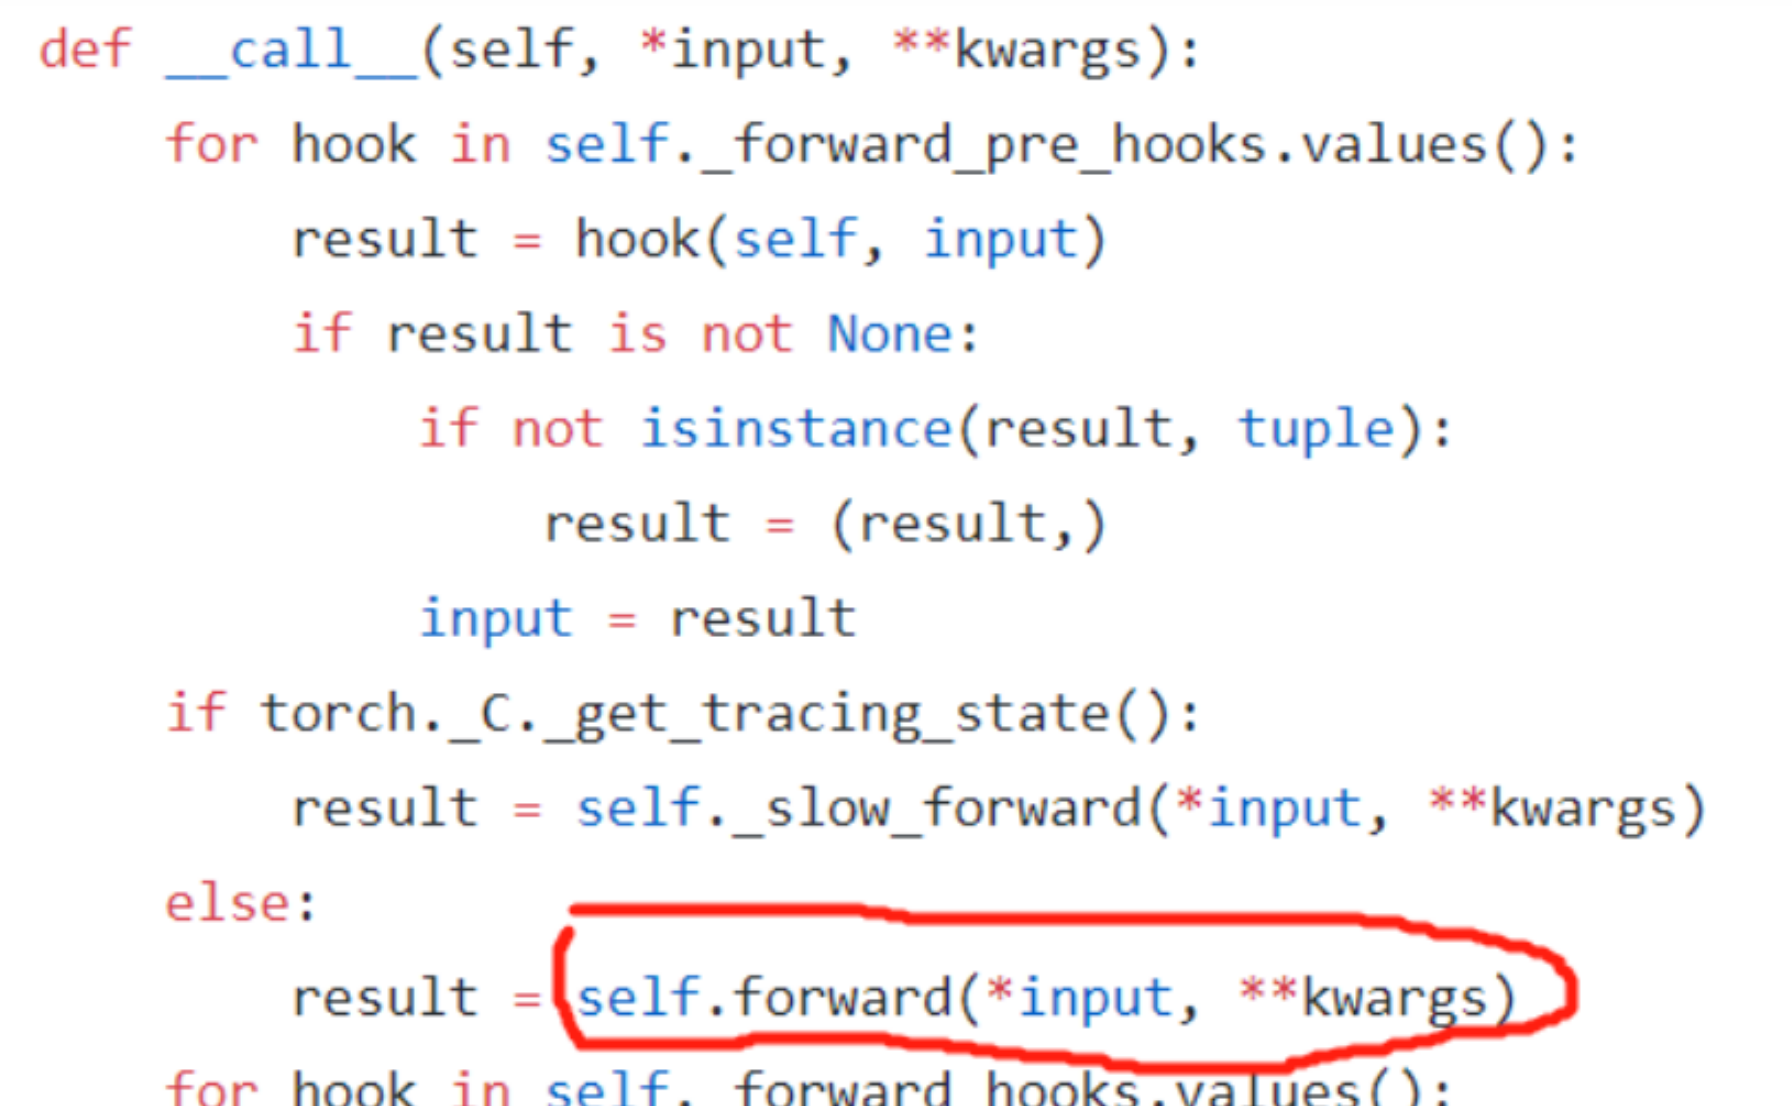

**call方法的介绍**

__call__() 方法可以用来将类实例变成为可调用对象,。简单的理解就是让类在调用call这个实例方法的时候跟普通函数一样，直接用“对象名（）”就可以，不需要再写”对象名.__call__()”，__call__实例方法不只可以调用forward，有的时候需要封装其他功能进去。这样使用主要是为了方便。

现在，我们可以[**将层作为组件合并到更复杂的模型中**]。就是将我们创建的层组合成块

In [11]:
net=nn.Sequential(nn.Linear(8,128),CenteredLayer())

作为额外的健全性检查，我们可以在向该网络发送随机数据后，检查均值是否为0。
由于我们处理的是浮点数，因为存储精度的原因，我们仍然可能会看到一个非常小的非零数。
​

In [13]:
Y=net(torch.rand(4,8))#将数据传到网络中
print(Y.shape)
Y.mean()

torch.Size([4, 128])


tensor(9.3132e-09, grad_fn=<MeanBackward0>)

## 5.4.2.[**带参数的层**]

以上我们知道了如何定义简单的层，下面我们继续定义具有参数的层，
这些参数可以通过训练进行调整。
我们可以使用内置函数（__init__函数）来创建参数，这些函数提供一些基本的管理功能。
比如管理访问、初始化、共享、保存和加载模型参数。
这样做的好处之一是：我们不需要为每个自定义层编写自定义的序列化程序。

现在，让我们实现自定义版本的全连接层。
回想一下，该层需要两个可学习的参数，一个用于表示权重，另一个用于表示偏置项。
在此实现中，我们使用ReLU()函数作为激活函数。
建立的全连接层需要输入参数：`in_units`和`units`，分别表示输入数和输出数。

**我们定义了一个简单的层，该层相当于一个含有激活函数ReLU的隐藏层，并且能够改变输入数和输出数，并且隐藏层的权重和偏置也是自己定义的（权重和偏执按照标准正态分布进行随机初始化的）**


In [15]:
class MyLinear(nn.Module):
    def __init__(self,in_units,units):#in_units,units是两个输入参数
        super().__init__()#继承父类的__init__
        #没有nn.Parameter，linear.weight结果中就没有梯度无法进行反向传播计算
        self.weight=nn.Parameter(torch.randn(in_units,units))#生成了in_units*units的服从标准正态分布的随机数，nn.Parameter模块会对传入的参数torch.randn(in_units,units)自动加上梯度，那么就可以通过反向传播函数进行更新参数(权重和偏置)，实现训练目的
        #偏置，但一般将偏置设为0,我们这里只是为了举个例子，并没有实际意义
        self.bias=nn.Parameter(torch.randn(units,))##生成了长度为units的服从标准正态分布的随机向量，也可以nn.Parameter(torch.randn(units))

    def forward(self,x):
        linear=torch.matmul(x,self.weight.data)+self.bias.data#去掉了梯度，如果直接是self.weight那么包含了梯度,因为我们的linear不需要调用反向传播函数进行更新所以去掉了梯度。
        return F.relu(linear)#对linear调用激活函数，类似于带有激活函数ReLU的隐藏层

print(torch.randn(5,).shape)#是一个一维的张量
print(torch.randn(5).shape)#是一个一维的张量
print(torch.randn(5,1).shape)#是个二维的张量

torch.Size([5])
torch.Size([5])
torch.Size([5, 1])


### nn.Parameters()函数的简单介绍
**首先可以把这个函数理解为类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter绑定到这个module里面**

链接：https://www.jianshu.com/p/d8b77cc02410


上面就定义了一个线性全连接层，我们可以自己改变输入和输出。接下来，我们实例化`MyLinear`类并访问其模型参数

In [17]:
linear=MyLinear(5,3)#in_units=5,unites=3,
linear.weight#访问实例属性

Parameter containing:
tensor([[-0.0282, -0.4677,  1.5721],
        [ 0.9468,  0.1534, -0.4270],
        [ 1.0280, -2.2134,  1.1920],
        [ 0.5839,  0.3828, -0.2718],
        [-0.4037,  0.0070,  0.6646]], requires_grad=True)

我们可以[**使用自定义层直接执行前向传播计算**]。


In [18]:
linear(torch.rand(2,5))#linear是一个输入数是5，输出数是3，所以输出的结果是2*3的二位张量,将数据传给定义的层

tensor([[0.4298, 0.0000, 0.2503],
        [0.0000, 0.0000, 1.0016]])

我们还可以(**使用自定义层构建模型**)。


In [19]:
net=nn.Sequential(MyLinear(64,8),MyLinear(8,1))#第一个第二个是我们自己定义的层
print(net(torch.rand(2,64)))#将数据传递给模型输出结果

tensor([[4.8311],
        [6.6824]])


## 小结

* 我们可以通过基本层类设计自定义层。这允许我们定义灵活的新层，其功能与深度学习框架中的任何现有层不同。
* 在层自定义完成后，我们就可以在任意环境和网络架构中调用该自定义层。
* 层可以有局部参数，这些参数可以通过内置函数创建。

